In [17]:
from mesa import Agent
from mesa import Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

# Constant

In [18]:
ticks = 3600 # 3600 ticks = 3600 seconds = 1 hour
no_customers = 500
avg_service_time = 45 # ticks/seconds per customer
gross_margin_per_customer = 10 # dollars
cost_per_counter = 300 # dollars

In [19]:
class Customer(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        # Time required to process the customer's transaction
        self.service_time = ss.poisson(45).rvs()
        # Time of arrival at queue
        self.entry_time = np.int(ss.beta(3, 3).rvs() * ticks) + 1
        self.balk_tolerance = ss.poisson(5).rvs() + 1
        # Whether or not the customer has arrived at the queue
        self._arrived = False
        self._chosen_counter = None
        self._q_entry = None
        self._q_exit = None
        # Start time when customer is being served
        self._service_entry = None
        # End time
        self._service_exit = None

    def select_counter(self):
        self._arrived = True
        # Queue at shortest counter
        self._chosen_counter_idx = np.argmin([
            len(counter.queue) for counter in self.model.counters])
        self._chosen_counter = self.model.counters[
            self._chosen_counter_idx]
        # Balk if there are too many people at the counter
        if len(self._chosen_counter.queue) < self.balk_tolerance:
            self._chosen_counter.queue.append(self)
            self._q_entry = self.model._current_tick
            
    def pay_n_leave(self):
        self._service_exit = self.model._current_tick
        self._chosen_counter.active_customer = None
    def step(self):
        if (self._arrived == False) & (self.model._current_tick >= self.entry_time):
            self.select_counter()
        elif isinstance(self._service_entry, int):
            if self.model._current_tick - self._service_entry == self.service_time:
                self.pay_n_leave()

In [20]:
class Counter(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.queue = []
        self.active_customer = None
    def dequeue(self):
        try:
            self.active_customer = self.queue.pop(0)
            self.active_customer._service_entry = self.model._current_tick
            self.active_customer._q_exit = self.model._current_tick
        except:
            pass
    def step(self):
        if self.active_customer is None:
            self.dequeue()

In [21]:
def get_customers_arrived(model):
    customers_arrived = [
        customer._arrived for customer in model.customers]
    no_customers_arrived = np.sum(customers_arrived)
    return no_customers_arrived
def get_customers_served(model):
    customers_served = [not(customer._service_exit is None)
                        for customer in model.customers]
    no_customers_served = np.sum(customers_served)
    return no_customers_served
def get_customers_balked(model):
    customers_arrived = [
        customer._arrived for customer in model.customers]
    # Customers who never joined a queue
    customers_no_q = np.array([
        customer._q_entry is None for customer in model.customers])
    no_customers_balked = np.sum(customers_arrived * customers_no_q)
    return no_customers_balked
def get_avg_queue_size(model):
    queue_size = [len(counter.queue) for counter in model.counters]
    avg_queue_size = np.mean(queue_size)
    return avg_queue_size
def get_avg_waiting_time(model):
    customers_wait = [np.nan if customer._q_exit is None else
                      customer._q_exit - customer._q_entry for customer in model.customers]
    avg_customer_wait = np.nanmean(customers_wait)
    return avg_customer_wait
def get_gross_margin(model):
    return gross_margin_per_customer * get_customers_served(model)
def get_operating_costs(model):
    return cost_per_counter * no_counters
def get_total_profit(model):
    return get_gross_margin(model) - get_operating_costs(model)


In [22]:

class QueueModel(Model):
    """Queueing model with customers and counters as two
    types of agents that interact with each other
    """
    def __init__(self, no_customers, no_counters, ticks):
        self.ticks = ticks
        self._current_tick = 1
        self.no_customers = no_customers
        self.no_counters = no_counters
        self.schedule = RandomActivation(self)
        # Create agents
        self.customers = []
        self.counters = []
        for i in range(self.no_customers):
            customer = Customer(i, self)
            self.schedule.add(customer)
            self.customers.append(customer)
        for i in range(self.no_counters):
            counter = Counter(i + no_customers, self)
            self.schedule.add(counter)
            self.counters.append(counter)
        self.datacollector = DataCollector(
            model_reporters={
    'Customers Arrived': get_customers_arrived,                      
    'Customers Served': get_customers_served,
    'Customers Balked': get_customers_balked,
    'Average Waiting Time': get_avg_waiting_time,
    'Average Queue Size': get_avg_queue_size,
    'Gross Margin': get_gross_margin,
    'Operating Costs': get_operating_costs,
    'Total Profit': get_total_profit})
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        self._current_tick += 1

In [23]:
no_counters = 5
model = QueueModel(ticks=ticks,
    no_customers=no_customers, no_counters=no_counters)
for i in range(ticks):
    model.step()

C:\Users\leona\AppData\Local\Temp/ipykernel_20792/3671336259.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.entry_time = np.int(ss.beta(3, 3).rvs() * ticks) + 1
C:\Users\leona\AppData\Local\Temp/ipykernel_20792/3786403873.py:26: RuntimeWarning: Mean of empty slice
  avg_customer_wait = np.nanmean(customers_wait)


C:\Users\leona\AppData\Local\Temp/ipykernel_20792/1346097171.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


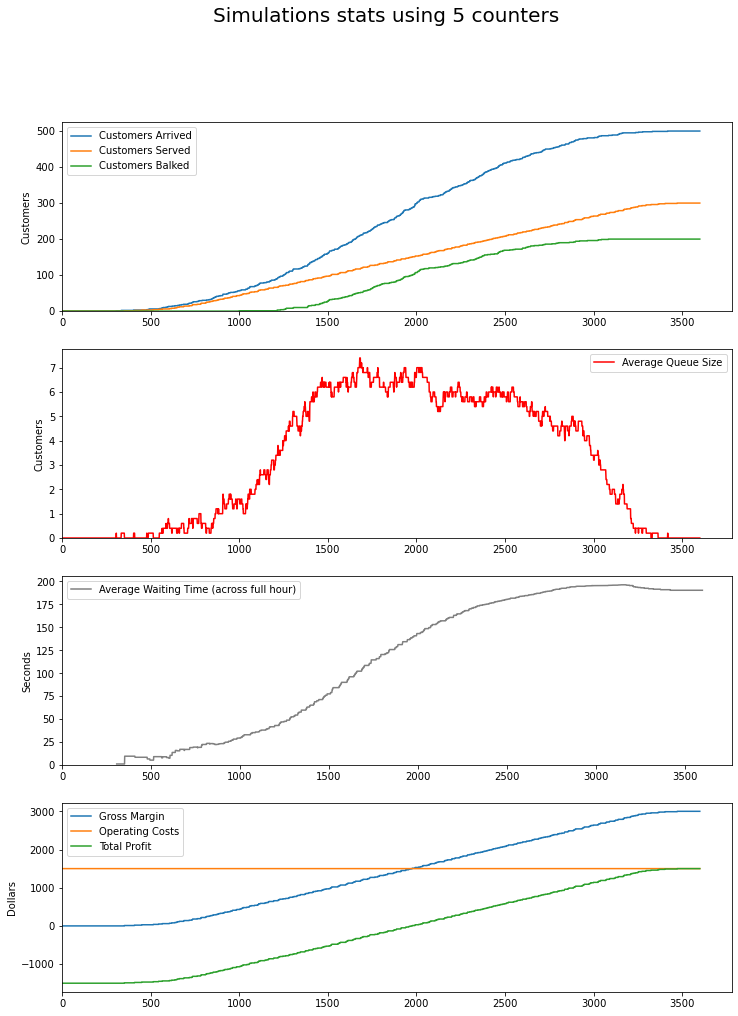

In [24]:
run_stats = model.datacollector.get_model_vars_dataframe()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1)
fig.figure.set_figwidth(12)
fig.figure.set_figheight(16)
fig.suptitle(f'Simulations stats using {no_counters} counters', fontsize=20)
ax1.plot(run_stats[['Customers Arrived',
                'Customers Served',
                'Customers Balked',
               ]])
ax1.legend(['Customers Arrived',
            'Customers Served',
            'Customers Balked',
            ])
ax1.set_ylabel('Customers')
ax1.set_xlim(0)
ax1.set_ylim(0)
ax2.plot(run_stats['Average Queue Size'], color='red')
ax2.legend(['Average Queue Size'])
ax2.set_ylabel('Customers')
ax2.set_xlim(0)
ax2.set_ylim(0)
ax3.plot(run_stats['Average Waiting Time'], color='grey')
ax3.legend(['Average Waiting Time (across full hour)'])
ax3.set_ylabel('Seconds')
ax3.set_xlim(0)
ax3.set_ylim(0)
ax4.plot(run_stats[['Gross Margin',
                'Operating Costs',
                'Total Profit'
               ]])
ax4.legend(['Gross Margin',
            'Operating Costs',
            'Total Profit'
            ])
ax4.set_ylabel('Dollars')
ax4.set_xlim(0)
fig.show()


In [25]:
full_stats = {}
for no_counters in range (5, 16):
    model = QueueModel(ticks=ticks,
    no_customers=no_customers, no_counters=no_counters)
    for i in range(ticks):
        model.step()   
    run_stats = model.datacollector.get_model_vars_dataframe()
    full_stats[no_counters] = run_stats.iloc[-1]
    
pd.DataFrame(full_stats).transpose().astype(int)

C:\Users\leona\AppData\Local\Temp/ipykernel_20792/3671336259.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.entry_time = np.int(ss.beta(3, 3).rvs() * ticks) + 1
C:\Users\leona\AppData\Local\Temp/ipykernel_20792/3786403873.py:26: RuntimeWarning: Mean of empty slice
  avg_customer_wait = np.nanmean(customers_wait)


NameError: name 'pd' is not defined